# Neural Network Development Notebook

In [91]:
# %% Load libraries
import jax
import equinox as eqx
import numpy as np
import matplotlib.pyplot as plt
from jaxtyping import Float, Array, PyTree
import jax.numpy as jnp
import optax
from typing import Iterator, Tuple

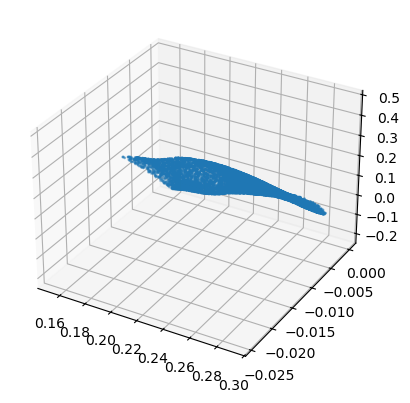

In [163]:
# %% Load and filter data
%matplotlib inline
orbit_data = np.load('./tests/orbit_data.npz')

lphi = orbit_data['lphi']
action = orbit_data['action']
ham = orbit_data['ham']
winding_pol = orbit_data['winding_pol']
winding_vll = orbit_data['winding_vll']
omega_tor = orbit_data['omega_tor']
omega_pol = orbit_data['omega_pol']

pfilter = np.logical_and((np.isclose(winding_pol, 0, atol=1e-2)), (np.isclose(winding_vll, 1, atol=1e-2)))

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(lphi[pfilter], action[pfilter], ham[pfilter], s=1)

In [164]:
# %% Define neural network
class NeuralNetwork(eqx.Module):
    layers: list

    def __init__(self, key):
        keys = jax.random.split(key, 5)

        self.layers = [
            eqx.nn.Linear(2, 64, key=keys[0]),
            jax.nn.tanh,
            eqx.nn.Linear(64, 64, key=keys[1]),
            jax.nn.tanh,
            eqx.nn.Linear(64, 64, key=keys[2]),
            jax.nn.tanh,
            eqx.nn.Linear(64, 1, key=keys[4])
        ]

    def __call__(self, x: Float[Array, "2"]) -> Float[Array, "1"]:
        for layer in self.layers:
            x = layer(x)
        return x

In [165]:
# %% Define data loader
def data_loader(
        X: Float[Array, "Ndata 2"],
        Y: Float[Array, "Ndata 1"],
        batch_size: int,
        *,
        key: Array | None = None,
        shuffle: bool = True,
        ) -> Iterator[Tuple[Float[Array, "{batch_size} 2"],
                            Float[Array, "{batch_size} 1"]]]:
    Ndata = X.shape[0]

    if key is None:
        key = jax.random.PRNGKey(0)
        
    if shuffle:
        perm = jax.random.permutation(key, Ndata)
    else:
        perm = jnp.arange(Ndata)

    Nbatch = Ndata // batch_size

    for i in range(Nbatch):
        start = i * batch_size
        end = start + batch_size
        indices = perm[start:end]

        yield (jnp.array(X[indices,:]),
               jnp.array(Y[indices,:]))

In [166]:
# %% Define the loss function
@eqx.filter_jit
def loss(
        model: NeuralNetwork,
        x: Float[Array, "batch 2"],
        y_true: Float[Array, "batch 1"]
) -> Float:
    y_pred = jax.vmap(model)(x)
    return jnp.mean((y_pred - y_true) ** 2)

In [167]:
key = jax.random.key(0)
model0 = NeuralNetwork(key)

x_all = jnp.array(np.vstack((lphi[pfilter], action[pfilter])).T)
y_all = jnp.array([ham[pfilter]]).T

loss(model0, x_all, y_all)

Array(0.02851192, dtype=float32)

In [168]:
# %% Train the model

optim = optax.adamw(1e-3)

model = model0
opt_state = optim.init(eqx.filter(model, eqx.is_array))

@eqx.filter_jit
def make_step(
    model: NeuralNetwork,
    opt_state: PyTree,
    x: Float[Array, "batch 2"],
    y: Float[Array, "batch 1"],
):
    loss_value, grads = eqx.filter_value_and_grad(loss)(model, x, y)
    updates, opt_state = optim.update(
        grads, opt_state, eqx.filter(model, eqx.is_array)
    )
    model = eqx.apply_updates(model, updates)
    return model, opt_state, loss_value

# Select a subset of data for training
n_train = 2048
x_train = x_all[:n_train,:]
y_train = y_all[:n_train,:]

losses = []

for epoch in range(500):

    for batch in data_loader(x_train, y_train, batch_size=64, key=jax.random.PRNGKey(epoch)):
        x_batch, y_batch = batch

        model, opt_state, loss_value = make_step(
            model,
            opt_state,
            x_batch,
            y_batch
        )
    losses.append(loss_value)
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss_value}")

Epoch 0, Loss: 0.019806217402219772
Epoch 10, Loss: 0.0010532763553783298
Epoch 20, Loss: 0.002916996832937002
Epoch 30, Loss: 0.0009154058061540127
Epoch 40, Loss: 0.0022929757833480835
Epoch 50, Loss: 0.0008710157708264887
Epoch 60, Loss: 0.0009005843894556165
Epoch 70, Loss: 0.0008757291361689568
Epoch 80, Loss: 0.0006814421503804624
Epoch 90, Loss: 0.00111155747435987
Epoch 100, Loss: 0.0006634914316236973
Epoch 110, Loss: 0.0010543324751779437
Epoch 120, Loss: 0.0006623762892559171
Epoch 130, Loss: 0.0006358576938509941
Epoch 140, Loss: 0.0012029920471832156
Epoch 150, Loss: 0.0002644043415784836
Epoch 160, Loss: 0.00010086542170029134
Epoch 170, Loss: 0.00010050236596725881
Epoch 180, Loss: 0.0003079660818912089
Epoch 190, Loss: 0.00010458732867846265
Epoch 200, Loss: 0.00016906022210605443
Epoch 210, Loss: 7.847743108868599e-05
Epoch 220, Loss: 7.860265031922609e-05
Epoch 230, Loss: 0.00021331659809220582
Epoch 240, Loss: 7.957255002111197e-05
Epoch 250, Loss: 9.578881144989282e

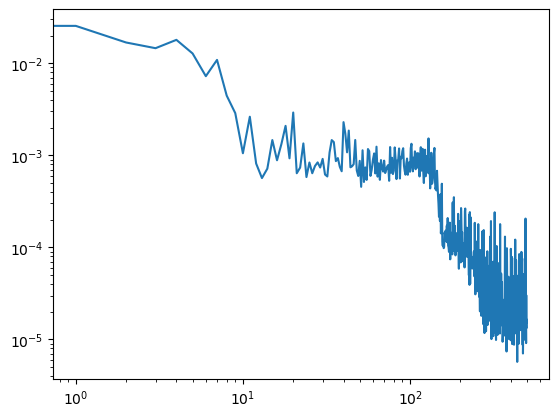

In [169]:
plt.figure()
plt.loglog(losses)

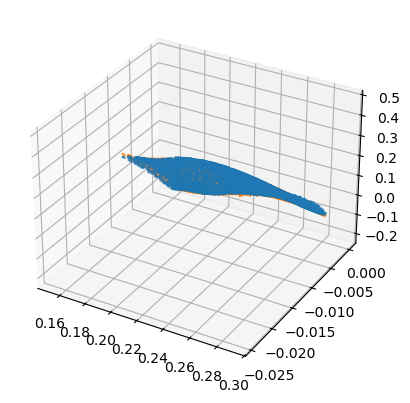

In [170]:
# %% Test the model
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(lphi[pfilter], action[pfilter], ham[pfilter], s=1)
ax.scatter(lphi[pfilter], action[pfilter], jax.vmap(model)(x_all)[:,0], s=1)

In [171]:
def flat_model(x):
    return model(x)[0]

j = jax.jacrev(flat_model)
hess = jax.jacfwd(j)

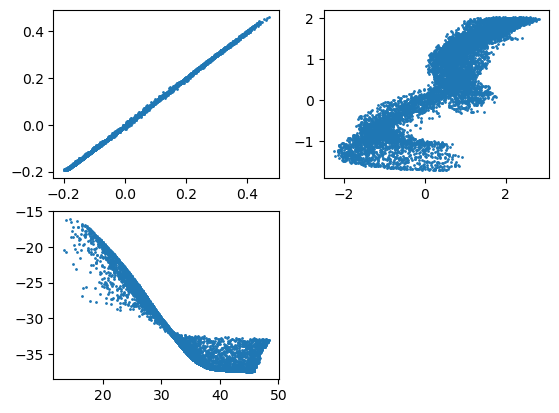

In [172]:
# %% More model tests
%matplotlib inline
plt.figure()

ax = plt.subplot(2, 2, 1)
ax.scatter(ham[pfilter], jax.vmap(model)(x_all)[:,0], s=1)

jac_all = jax.vmap(j)(x_all)

ax = plt.subplot(2, 2, 2)
ax.scatter(omega_tor[pfilter], jac_all[:,0], s=1)

ax = plt.subplot(2, 2, 3)
ax.scatter(omega_pol[pfilter], jac_all[:,1], s=1)

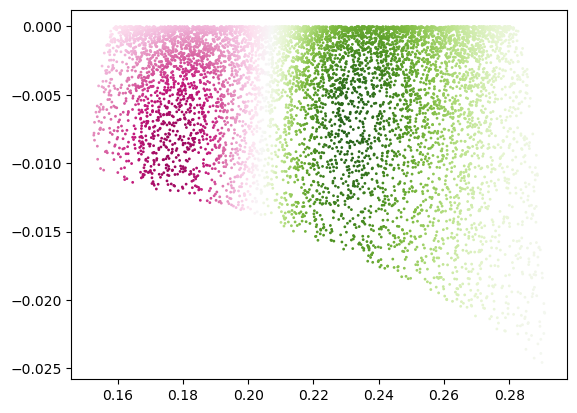

In [173]:
hess_all = jax.vmap(hess)(x_all)

det_all = hess_all[:,0,0] * hess_all[:,1,1] - hess_all[:,0,1] * hess_all[:,1,0]
det_max = np.max(np.abs(det_all))

plt.figure()
plt.scatter(lphi[pfilter], action[pfilter], c=det_all, vmin=-det_max, vmax=det_max, cmap='PiYG', s=1)